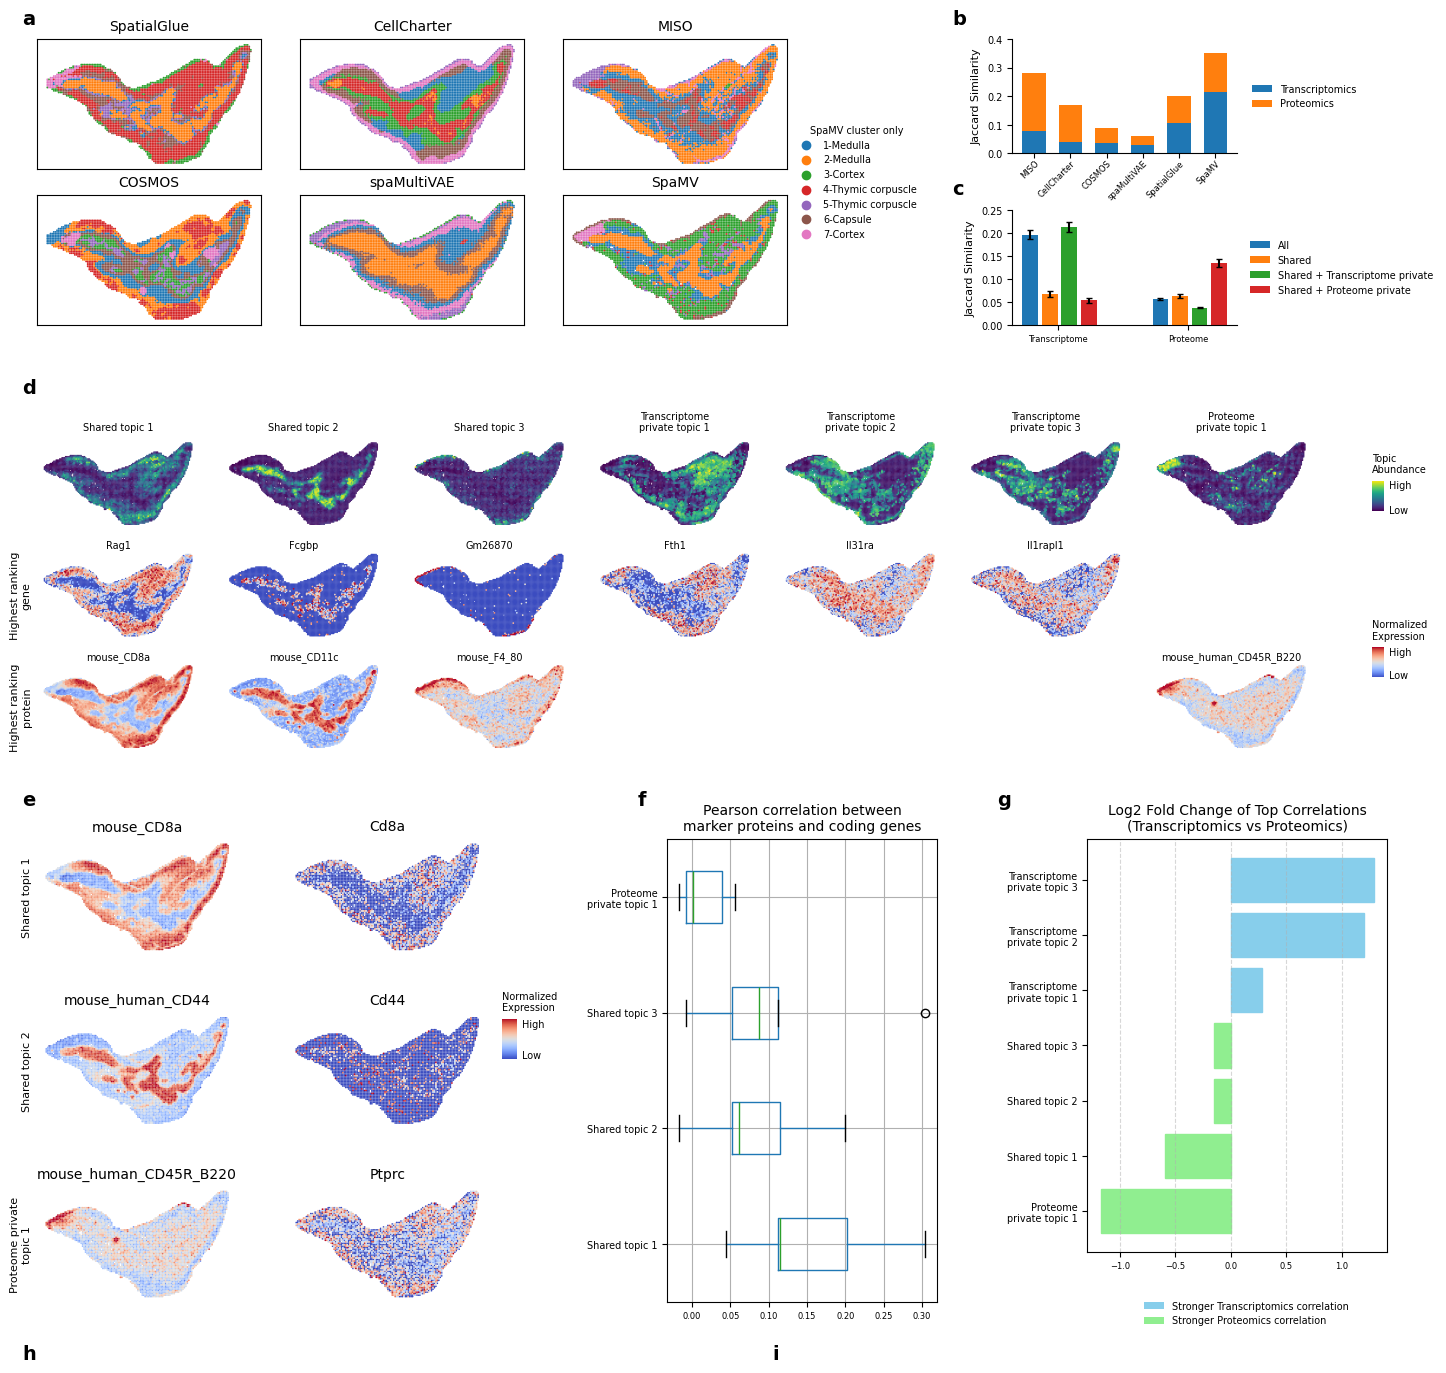

In [20]:
import math
import textwrap
import matplotlib
import warnings
import sys
import os
from scipy.stats import pearsonr
# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(current_dir))
from SpaMV.utils import compute_gene_topic_correlations

warnings.filterwarnings("ignore")
import numpy as np
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.patches import Patch
font = {'size': 7}
plt.rc('font', size=8)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=6)

matplotlib.rc('font', **font)
dataset = 'Mouse_Thymus'
# load mouse embryo dataset
data_rna = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')

cluster_size = 7
topic_size = 6
dr_size = 50
width = 15
height = 14.2
width_ratio=.5
clustering_scale = {'top':1 - 1/height, 'bottom':1 - (1 + width_ratio * width / 1.75 / 3 * 2)/height, 'left': .05, 'right': width_ratio +.05}
legend_scale = {'top':1 - 1/height, 'bottom':1 - (1 + width_ratio * width / 1.75 / 3 * 2)/height, 'left': width_ratio +.05, 'right': width_ratio + .105}
score_scale = {'top':1 - 1/height, 'bottom':1 - (1 + width_ratio * width / 1.75 / 3 * 2)/height, 'left': width_ratio+.2, 'right': .85}
width_ratio = .85
dr_scale = {'top': 1-5/height, 'bottom': 1-(5 + width_ratio * width / 1.75 / 7 * 3)/height,'left': .05, 'right': width_ratio + .05}
topic_colorbar_scale = {'top': 1-(5+1.7/3-.15)/height, 'bottom': 1-(5+1.7/3+.15)/height, 'left':.94, 'right': .948}
feature_colorbar_scale = {'top': 1-(5+6.7/3-.15)/height, 'bottom': 1-(5+6.7/3+.15)/height, 'left':.94, 'right': .948}
width_ratio=.3
coding_gene_scale = {'top': 1 - 9/height, 'bottom': 1 - (9 + width_ratio * width / 1.75 / 2 * 3*1.2)/height, 'left': .05, 'right': width_ratio + .05}
coding_gene_colorbar_scale = {'top': 1 - 10.8/height, 'bottom': 1 - 11.2/height, 'left': width_ratio + .06, 'right': width_ratio + .07}
gene_pro_corre_scale = {'top': 1 - 9/height, 'bottom': 1 - (9 + width_ratio * width / 1.75 / 2 * 3 * 1.2)/height, 'left': width_ratio + .17, 'right': .65}
correlation_scale = {'top': 1 - 9/height, 'bottom': 1 - (9 + width_ratio * width / 1.75 / 2 * 3 * 1.2 - .5)/height, 'left': .75, 'right': .95}
pathway_scale = {'top': 1 - (9 + width_ratio * width / 1.75 / 2 * 3 * .8)/height, 'bottom': 15}
fig = plt.figure(figsize=(width, height))
###############################################################################################################################
# plot clustering results
spec_clustering = GridSpec(2, 3, hspace=.2, wspace=.2*1.75/2)
spec_clustering.update(**clustering_scale)

f_dict = {}
f_dict['SpatialGlue'] = plt.subplot(spec_clustering[0, 0])
f_dict['CellCharter'] = plt.subplot(spec_clustering[0, 1])
f_dict["MISO"] = plt.subplot(spec_clustering[0, 2])
f_dict['COSMOS'] = plt.subplot(spec_clustering[1, 0])
f_dict['spaMultiVAE'] = plt.subplot(spec_clustering[1, 1])
f_dict['SpaMV'] = plt.subplot(spec_clustering[1, 2])


data_methods = {}
data_methods['SpaMV'] = sc.read_h5ad('../Results/' + dataset + '/SpaMV.h5ad')
data_methods['SpaMV'].obs['SpaMV'] = data_methods['SpaMV'].obs['SpaMV'].astype(int).map({1: '1-Medulla', 2: '2-Medulla', 3: '3-Cortex', 4: '4-Thymic corpuscle', 5: '5-Thymic corpuscle', 6: '6-Capsule', 7: '7-Cortex'}).astype('category')
sc.pl.embedding(data_methods['SpaMV'], basis='spatial', color='SpaMV', ax=f_dict['SpaMV'], show=False, size=cluster_size)
for method in ['COSMOS', 'CellCharter', 'SpatialGlue', 'MISO', 'spaMultiVAE']:
    data_methods[method] = sc.read_h5ad('../Results/' + dataset + '/' + method + '.h5ad')
    data_methods[method].obs[method] = data_methods[method].obs[method].astype('category')
    sc.pl.embedding(data_methods[method], basis='spatial', color=method, ax=f_dict[method], show=False, size=cluster_size)

spec_legend = GridSpec(1, 1)
spec_legend.update(**legend_scale)
legend = plt.subplot(spec_legend[0, 0])
handles, labels = f_dict['SpaMV'].get_legend_handles_labels()
legend.legend(handles, labels, loc='center left', frameon=False, title="SpaMV cluster only")
legend.axis('off')
for f in f_dict.values():
    f.get_legend().remove()
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

###############################################################################################################################
# plot clutering evaluation results
# plot unsupervised results
spec_score = GridSpec(2, 1, hspace=.5)
spec_score.update(**score_scale)
evaluation_spamv = pd.read_csv('../Results/' + dataset + '/Evaluation_SpaMV.csv')
evaluation_miso = pd.read_csv('../Results/' + dataset + '/Evaluation_MISO.csv')
evaluation_cosmos = pd.read_csv('../Results/' + dataset + '/Evaluation_COSMOS.csv')
evaluation_spatialglue = pd.read_csv('../Results/' + dataset + '/Evaluation_SpatialGlue.csv')
evaluation_cellcharter = pd.read_csv('../Results/' + dataset + '/Evaluation_CellCharter.csv')
evaluation_spamultivae = pd.read_csv('../Results/' + dataset + '/Evaluation_spaMultiVAE.csv')

unsupervised = plt.subplot(spec_score[0, 0])
melted_df = evaluation_spamv
for df in [evaluation_miso, evaluation_cosmos, evaluation_spatialglue, evaluation_cellcharter, evaluation_spamultivae]:
    melted_df = pd.merge(melted_df, df, how='outer')

melted_df = melted_df[melted_df['Dataset'] == dataset]
metrics = ['jaccard 1', 'jaccard 2']  # your metrics
methods = ['MISO', 'CellCharter', 'COSMOS', 'SpatialGlue', 'SpaMV', 'SpaMV (Shared)', 'SpaMV (Transcriptomics related)', 'SpaMV (Proteomics related)']
melted_df = melted_df.drop(['Dataset'], axis=1)
# Calculate mean and standard deviation for each algorithm and metric
df_means = melted_df.groupby('method').mean().reset_index()
df_errors = melted_df.groupby('method').std().reset_index()

# Reshape the DataFrames for plotting
df_means_melted = df_means.melt(id_vars='method', var_name='Metric', value_name='Mean')
df_errors_melted = df_errors.melt(id_vars='method', var_name='Metric', value_name='Std')

# Merge the dataframes to include errors
df_combined = pd.merge(df_means_melted, df_errors_melted, on=['method', 'Metric'])

x = np.arange(len(metrics))  # the label locations
width = 0.08  # the width of the bars
cat_width=.8
colors = {'MISO': '#1f77b4', 'COSMOS': '#ff7f0e', 'spaMultiVAE': '#8c564b', 'CellCharter': '#2ca02c', 'SMOPCA': '#9467bd', 'SpatialGlue': '#bcbd22', 'SpaMV': '#d62728'}
ms = ['MISO', 'CellCharter', 'COSMOS', 'spaMultiVAE', 'SpatialGlue', 'SpaMV']
values = {}
bar_width = 0.64 
for o in ['Transcriptomics', 'Proteomics']:
    values[o] = []
    for method in ms[:-1]:
        if o == 'Transcriptomics':
            values[o].append(melted_df[melted_df['method'] == method]['jaccard 1'].mean())
        else:
            values[o].append(melted_df[melted_df['method'] == method]['jaccard 2'].mean())
    if o == 'Transcriptomics':
        values[o].append(melted_df[melted_df['method'] == 'SpaMV (Transcriptomics related)']['jaccard 1'].mean())
    else:
        values[o].append(melted_df[melted_df['method'] == 'SpaMV (Proteomics related)']['jaccard 2'].mean())

bottom = np.zeros(len(ms))

for boolean, weight_count in values.items():
    p = unsupervised.bar(ms, weight_count, bar_width, label=boolean, bottom=bottom)
    bottom += weight_count
# Add labels and title
unsupervised.set_ylabel('Jaccard Similarity')
unsupervised.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)
unsupervised.axes.set_xticklabels(labels=ms, rotation=45, ha='right', rotation_mode='anchor')
unsupervised.axes.xaxis.set_tick_params(pad=0)
unsupervised.set_ylim([0, .4])
# unsupervised.set_ylim([0, ymax])

# Remove the top and right spines
unsupervised.spines['top'].set_visible(False)
unsupervised.spines['right'].set_visible(False)

# Remove the x-axis label
unsupervised.set_xlabel('')  # Set the x-axis label to an empty string


# plot unsupervised results
unsupervised_spamv = plt.subplot(spec_score[1, 0])
melted_df = evaluation_spamv
for df in [evaluation_miso, evaluation_cosmos, evaluation_spatialglue, evaluation_cellcharter, evaluation_spamultivae]:
    melted_df = pd.merge(melted_df, df, how='outer')

melted_df = melted_df[melted_df['Dataset'] == dataset]
melted_df = melted_df.drop(['Dataset'], axis=1)
methods = ['SpaMV', 'SpaMV (Shared)', 'SpaMV (Transcriptomics related)', 'SpaMV (Proteomics related)']
mean_scores = melted_df.groupby('method').mean().reset_index()
std_scores = melted_df.groupby('method').std().reset_index()

# Reshape the DataFrames for plotting
df_means_melted = mean_scores.melt(id_vars='method', var_name='Metric', value_name='Mean')
df_errors_melted = std_scores.melt(id_vars='method', var_name='Metric', value_name='Std')

# Merge the dataframes to include errors
df_combined = pd.merge(df_means_melted, df_errors_melted, on=['method', 'Metric'])

x = np.arange(2)  # the label locations

cat_width = .6
width = cat_width / 4 * .8 # the width of the bars
colors = {'MISO': '#1f77b4', 'COSMOS': '#ff7f0e', 'spaMultiVAE': '#8c564b', 'CellCharter': '#2ca02c', 'SMOPCA': '#9467bd', 'SpatialGlue': '#bcbd22', 'SpaMV': '#d62728'}
# Plot bars for each method
for i, method in enumerate(methods):
    offset = cat_width * i / 4 - (.65-width*4)/.8
    algo_data = df_combined[df_combined['method'] == method]
    if method == 'SpaMV (Transcriptomics related)':
        label = 'Shared + Transcriptome private'
    elif method == 'SpaMV (Proteomics related)':
        label = 'Shared + Proteome private'
    elif method == 'SpaMV (Shared)':
        label = "Shared"
    else:
        label = 'All'
    # unsupervised.bar(x + offset, mean_scores.loc[method], width, label=label, color=color, alpha=alpha, hatch=hatch)
    unsupervised_spamv.bar(x + offset, algo_data['Mean'], yerr=algo_data['Std'], width=width, capsize=2, label=label)

# Customize the plot
unsupervised_spamv.set_ylabel('Jaccard Similarity')
unsupervised_spamv.set_xticks(x)
unsupervised_spamv.set_xticklabels(['Transcriptome', 'Proteome'])
unsupervised_spamv.set_ylim([0, .25])
unsupervised_spamv.legend()
# Remove spines
unsupervised_spamv.spines['right'].set_visible(False)
unsupervised_spamv.spines['top'].set_visible(False)
unsupervised_spamv.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False)

###############################################################################################################################
# plot dimension reduction results
spec_dr = GridSpec(3, 7, wspace=.25*1.75*2/6, hspace=.25)
spec_dr.update(**dr_scale)
z = pd.read_csv('../Results/' + dataset + '/SpaMV_z.csv', index_col=0)
rna = sc.read_h5ad('../Results/' + dataset + '/adata_RNA_preprocessed.h5ad')
adt = sc.read_h5ad('../Results/' + dataset + '/adata_ADT_preprocessed.h5ad')

w = [pd.read_csv('../Results/' + dataset + '/SpaMV_w_Transcriptomics.csv', index_col=0), pd.read_csv('../Results/' + dataset + '/SpaMV_w_Proteomics.csv', index_col=0)]
col_dict = {}
si = 1
oi = 1
ti = 1
for topic in z.columns:
    if 'Shared' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(si)
        si += 1
    elif 'Transcriptomics' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(oi)
        oi += 1
    else:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(ti)
        ti += 1
z = z.rename(columns=col_dict)
w[0] = w[0].rename(columns=col_dict)
w[1] = w[1].rename(columns=col_dict)
rna.obs[z.columns] = z.values
f_dict = {}
j = 0
for topic in z.columns:
    f_dict[topic] = plt.subplot(spec_dr[0, j])
    # sq.pl.spatial_scatter(spamv_annotated, color=topic, ax=f_dict[topic], img_alpha=img_alpha, frameon=False, colorbar=False)
    sc.pl.embedding(rna, color=topic, ax=f_dict[topic], frameon=False, show=False, basis='spatial', size=topic_size)
    if 'Transcriptomics' in topic:
        label = 'Transcriptome\n' + topic.split(maxsplit=1)[1]
    elif 'Proteomics' in topic:
        label = 'Proteome\n' + topic.split(maxsplit=1)[1]
    else:
        label = topic
    f_dict[topic].set_title(label, fontsize=7)
    topic_cb = f_dict[topic].collections[0]
    f_dict[topic].collections[0].colorbar.remove()
    # rect = patches.FancyBboxPatch((0.35, 1.2), width=0.3, height=0.02, boxstyle='square, pad=.15', facecolor="grey", alpha=0.5, transform=f_dict[topic].transAxes, clip_on=False, linewidth=0)
    # f_dict[topic].add_patch(rect)
    if 'Shared' in topic or 'Transcriptomics' in topic:
        f_dict[topic + 'T'] = plt.subplot(spec_dr[1, j])
        # sq.pl.spatial_scatter(rna, color=w[0].nlargest(1, topic).index[0], ax=f_dict[topic + 'T'], img_alpha=img_alpha, colorbar=False)
        sc.pl.embedding(rna, color=w[0].nlargest(1, topic).index[0], ax=f_dict[topic + 'T'], basis='spatial', colorbar_loc=None, show=False, vmax='p99', cmap='coolwarm', size=topic_size)
        f_dict[topic + 'T'].set_title(w[0].nlargest(1, topic).index[0], fontsize=7, pad=0)
        f_dict[topic + 'T'].set_ylabel('Highest ranking\ngene' if j == 0 else '')
        # Remove the box (spines)
        f_dict[topic + 'T'].spines['top'].set_visible(False)
        f_dict[topic + 'T'].spines['right'].set_visible(False)
        f_dict[topic + 'T'].spines['left'].set_visible(False)
        f_dict[topic + 'T'].spines['bottom'].set_visible(False)
        f_dict[topic + 'T'].set_xlabel('')
    if 'Shared' in topic or 'Proteomics' in topic:
        f_dict[topic + 'P'] = plt.subplot(spec_dr[2, j])
        # sq.pl.spatial_scatter(met, color=w[1].nlargest(1, topic).index[0], ax=f_dict[topic + 'M'], img_alpha=img_alpha, colorbar=False)
        sc.pl.embedding(adt, color=w[1].nlargest(1, topic).index[0], ax=f_dict[topic + 'P'], basis='spatial', show=False, vmax='p99', cmap='coolwarm', size=topic_size)
        feature_cb = f_dict[topic + 'P'].collections[0]
        f_dict[topic + 'P'].collections[0].colorbar.remove()
        f_dict[topic + 'P'].set_title(w[1].nlargest(1, topic).index[0], fontsize=7, pad=0)
        f_dict[topic + 'P'].set_ylabel('Highest ranking\nprotein' if j == 0 else '')
        # Remove the box (spines)
        f_dict[topic + 'P'].spines['top'].set_visible(False)
        f_dict[topic + 'P'].spines['right'].set_visible(False)
        f_dict[topic + 'P'].spines['left'].set_visible(False)
        f_dict[topic + 'P'].spines['bottom'].set_visible(False)
        f_dict[topic + 'P'].set_xlabel('')
    j += 1

spec_topic_colorbar = GridSpec(1, 1)
spec_topic_colorbar.update(**topic_colorbar_scale)
topic_colorbar = plt.subplot(spec_topic_colorbar[0, 0])
tcb = plt.colorbar(topic_cb, cax=topic_colorbar)
vmin, vmax = z[topic].min() + .05, z[topic].max() - .1
# Define tick positions including intermediate ticks
num_ticks = 4  # Total number of ticks
ticks = np.linspace(vmin, vmax, num=num_ticks)

# Set the ticks on the colorbar
tcb.outline.set_visible(False)
tcb.set_ticks(ticks)

# Create labels where only the first and last are labeled
labels = ['Low'] + [''] * (num_ticks - 2) + ['High']

# Set these labels on the colorbar
tcb.ax.set_yticklabels(labels)
tcb.ax.tick_params(size=0)
tcb.ax.set_title('Topic\nAbundance', fontsize=7, loc='left')  # Set the label position to the top

spec_feature_colorbar = GridSpec(1, 1)
spec_feature_colorbar.update(**feature_colorbar_scale)
topic_colorbar = plt.subplot(spec_feature_colorbar[0, 0])
fcb = plt.colorbar(feature_cb, cax=topic_colorbar)
vmin, vmax = adt[:, w[1].nlargest(1, topic).index[0]].X.min() + .05, adt[:, w[1].nlargest(1, topic).index[0]].X.max() - 1.35
# Define tick positions including intermediate ticks
num_ticks = 4  # Total number of ticks
ticks = np.linspace(vmin, vmax, num=num_ticks)

# Set the ticks on the colorbar
fcb.outline.set_visible(False)
fcb.set_ticks(ticks)

# Create labels where only the first and last are labeled
labels = ['Low'] + [''] * (num_ticks - 2) + ['High']

# Set these labels on the colorbar
fcb.ax.set_yticklabels(labels)
fcb.ax.tick_params(size=0)
fcb.ax.set_title('Normalized\nExpression', fontsize=7, loc='left')  # Set the label position to the top    
###############################################################################################################################
# plot coding genes
def add_y_label(ax, label_name):
    ax.set_ylabel(label_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel('')
rna_ori = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')
sc.pp.filter_cells(rna_ori, min_genes=math.ceil(rna_ori.n_vars / 100))
sc.pp.normalize_total(rna_ori)
sc.pp.log1p(rna_ori)
spec_coding_gene = GridSpec(3, 2, hspace=.5, wspace=.5/2)
spec_coding_gene.update(**coding_gene_scale)
f_dict = {}
size=6
f_dict['mouse_CD8a'] = plt.subplot(spec_coding_gene[0, 0])
sc.pl.embedding(adt, color='mouse_CD8a', basis='spatial', vmax='p99', colorbar_loc=None, show=False, ax=f_dict['mouse_CD8a'], cmap='coolwarm', size=size)
# f_dict['mouse_CD8a'].set_title(w[1].nlargest(1, topic).index[0], fontsize=7)
add_y_label(f_dict['mouse_CD8a'], 'Shared topic 1')

f_dict['Cd8a'] = plt.subplot(spec_coding_gene[0, 1])
sc.pl.embedding(rna_ori, color='Cd8a', basis='spatial', vmax='p99', colorbar_loc=None, show=False, ax=f_dict['Cd8a'], frameon=False, cmap='coolwarm', size=size)

f_dict['mouse_human_CD44'] = plt.subplot(spec_coding_gene[1, 0])
sc.pl.embedding(adt, color='mouse_human_CD44', basis='spatial', vmax='p99', colorbar_loc=None, show=False, ax=f_dict['mouse_human_CD44'], cmap='coolwarm', size=size)
add_y_label(f_dict['mouse_human_CD44'], 'Shared topic 2')
f_dict['Cd44'] = plt.subplot(spec_coding_gene[1, 1])
sc.pl.embedding(rna_ori, color='Cd44', basis='spatial', vmax='p98', colorbar_loc=None, show=False, ax=f_dict['Cd44'], frameon=False, cmap='coolwarm', size=size)

f_dict['mouse_human_CD45R_B220'] = plt.subplot(spec_coding_gene[2, 0])
sc.pl.embedding(adt, color='mouse_human_CD45R_B220', basis='spatial', vmax='p99', colorbar_loc=None, show=False, ax=f_dict['mouse_human_CD45R_B220'], cmap='coolwarm', size=size)
add_y_label(f_dict['mouse_human_CD45R_B220'], 'Proteome private\ntopic 1')
f_dict['Ptprc'] = plt.subplot(spec_coding_gene[2, 1])
sc.pl.embedding(rna_ori, color='Ptprc', basis='spatial', vmax='p99', colorbar_loc=None, show=False, ax=f_dict['Ptprc'], frameon=False, cmap='coolwarm', size=size)

proteins_to_genes = {
    'mouse_CD5': 'Cd5',
    'mouse_CD4': 'Cd4',
    'mouse_CD68': 'Cd68',
    'mouse_rat_CD29': 'Itgb1',
    'mouse_CD8a': 'Cd8a',
    'mouse_CD3': 'Cd3e',
    'mouse_human_CD44': 'Cd44',
    'mouse_CD90_2': 'Thy1',
    'mouse_rat_human_CD27': 'Cd27',
    'mouse_CD11c': 'Itgax',
    'mouse_CD31': 'Pecam1',
    'mouse_F4_80': 'Adgre1',
    # Excluding complex genes Rat_IgG2a and Mouse_IgG2a
    'mouse_human_CD45R_B220': 'Ptprc',
    'mouse_CD19': 'Cd19',
    'mouse_human_CD11b': 'Itgam',
    'mouse_Siglec_H': 'Siglech',
    'mouse_CD169_Siglec-1': 'Siglec1'
}

spec_coding_gene_colorbar = GridSpec(1, 1)
spec_coding_gene_colorbar.update(**coding_gene_colorbar_scale)
coding_gene_colorbar = plt.subplot(spec_coding_gene_colorbar[0, 0])
fcb = plt.colorbar(feature_cb, cax=coding_gene_colorbar)
vmin, vmax = adt[:, w[1].nlargest(1, topic).index[0]].X.min() + .05, adt[:, w[1].nlargest(1, topic).index[0]].X.max() - 1.35
# Define tick positions including intermediate ticks
num_ticks = 4  # Total number of ticks
ticks = np.linspace(vmin, vmax, num=num_ticks)

# Set the ticks on the colorbar
fcb.outline.set_visible(False)
fcb.set_ticks(ticks)

# Create labels where only the first and last are labeled
labels = ['Low'] + [''] * (num_ticks - 2) + ['High']

# Set these labels on the colorbar
fcb.ax.set_yticklabels(labels)
fcb.ax.tick_params(size=0)
fcb.ax.set_title('Normalized\nExpression', fontsize=7, loc='left')  # Set the label position to the top    


rna_ori = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')
pro_ori = sc.read_h5ad('../Dataset/' + dataset + '/adata_ADT.h5ad')

pro_rank = w[1].rank(axis=0, ascending=False, method='min')
# Compute Pearson correlation between each pair of protein and coding gene
correlations = []
for protein, gene in proteins_to_genes.items():
    if protein in pro_ori.var_names and gene in rna_ori.var_names:
        protein_data = pro_ori[:, protein].X.toarray().flatten()
        gene_data = rna_ori[:, gene].X.toarray().flatten()
        corr, _ = pearsonr(protein_data, gene_data)
        correlations.append((protein, corr))

# Convert to DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Protein', 'Pearson Correlation'])

df = {}
for topic in w[1].columns:
    if 'Proteomics' in topic:
        label = 'Proteome\n' + topic.split(maxsplit=1)[1]
    else:
        label = topic
    df[label] = correlation_df.loc[correlation_df['Protein'].isin(pro_rank[topic].nsmallest(5 if 'Shared' in topic else 7).index.tolist()), 'Pearson Correlation']

df = pd.DataFrame(df)
spec_gene_pro_corre = GridSpec(1, 1)
spec_gene_pro_corre.update(**gene_pro_corre_scale)
boxplot = plt.subplot(spec_gene_pro_corre[0, 0])
df.boxplot(ax=boxplot, vert=False)
boxplot.set_title("Pearson correlation between\nmarker proteins and coding genes")
# boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

###############################################################################################################################
# plot correlation result
spec_correlation = GridSpec(1, 1)
spec_correlation.update(**correlation_scale)
dr_score = plt.subplot(spec_correlation[0, 0])
def plot_topic_correlation_ratio_multimodal(data, omics_names, z, ax, k_values=None):
    """
    Plot the log2 fold change of mean top-k correlations between modalities for each topic.

    Parameters
    ----------
    data_list : list
        List of AnnData objects, one for each modality
    omics_names : list
        List of strings containing names of each modality
    z : pandas.DataFrame
        Topic matrix where rows are cells and columns are topics
    k_values : dict or None
        Dictionary mapping modality names to their k values for top correlations
        If None, defaults to k=20 for RNA and k=5 for others
    figsize : tuple
        Figure size (width, height)
    """
    # Validate inputs
    if len(data) != len(omics_names):
        raise ValueError("Number of datasets must match number of omics names")
    if len(data) != 2:
        raise ValueError("This function currently supports exactly 2 modalities")

    # Set default k values if not provided
    if k_values is None:
        k_values = {name: 5 if name in ['Proteomics'] else 10 for name in omics_names}
        
    for topic in z.columns:
        if 'Transcriptomics' in topic:
            z = z.rename(columns={topic: 'Transcriptome ' + topic.split(maxsplit=1)[1]})
        elif 'Proteomics' in topic:
            z = z.rename(columns={topic: 'Proteome ' + topic.split(maxsplit=1)[1]})
    # Compute correlations for each modality
    modality_corrs = {}
    for data, name in zip(data, omics_names):
        corr_df, _ = compute_gene_topic_correlations(data, z)
        modality_corrs[name] = corr_df

    # Calculate mean top-k correlations for each modality
    topic_means = {name: [] for name in omics_names}

    for topic in z.columns:
        for name in omics_names:
            # Get top k correlations for this modality
            top_k_corrs = np.sort(modality_corrs[name][topic].values)[-k_values[name]:]
            topic_means[name].append(np.mean(top_k_corrs))

    # Calculate log2 fold change
    log2_fold_changes = np.log2(np.array(topic_means[omics_names[0]]) /
                               np.array(topic_means[omics_names[1]]))

    # Create DataFrame with results
    result_df = pd.DataFrame({'Topic': z.columns, 'Log2 Fold Change': log2_fold_changes})

    # Sort by log2 fold change
    result_df = result_df.sort_values('Log2 Fold Change', ascending=True)

    # Create horizontal bar plot
    bars = ax.barh(range(len(result_df)), result_df['Log2 Fold Change'])

    # Color bars based on which modality has stronger correlation
    for i, bar in enumerate(bars):
        if result_df['Log2 Fold Change'].iloc[i] > 0:
            bar.set_color('skyblue')  # First modality stronger
        else:
            bar.set_color('lightgreen')  # Second modality stronger

    # Customize the plot
    plt.title(f'Log2 Fold Change of Top Correlations\n({omics_names[0]} vs {omics_names[1]})')

    def split_label(label, threshold=10):
       if len(label) <= threshold:
           return label

       words = label.split()
       current_line = ""
       broken_label = ""

       for word in words:
           if len(current_line) + len(word) + 1 > threshold:
               broken_label += current_line.strip() + '\n'
               current_line = word + " "
           else:
               current_line += word + " "

       broken_label += current_line.strip()  # Add the last line
       return broken_label
   
   

    new_labels = [split_label(label, threshold=16) for label in result_df['Topic']]
    # Set topic names as y-axis labels
    plt.yticks(range(len(result_df)), new_labels)
    label1 = f'Stronger {omics_names[0]} correlation'
    label2 = f'Stronger {omics_names[1]} correlation'

    legend_elements = [Patch(facecolor='skyblue', label=label1), Patch(facecolor='lightgreen', label=label2)]
    plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(.9, -.2), frameon=False)
    # Add grid for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    return plt.gcf()

rna = sc.read_h5ad('../Results/' + dataset + '/adata_RNA_preprocessed.h5ad')
adt = sc.read_h5ad('../Results/' + dataset + '/adata_ADT_preprocessed.h5ad')
plot_topic_correlation_ratio_multimodal([rna, adt], ['Transcriptomics', 'Proteomics'], z, dr_score)

###############################################################################################################################
# plot pathway result
spec_pathway = GridSpec(1, 2)
spec_pathway.update(**pathway_scale)
def plot_enrichment_dotplot(df, ax, dot_color='steelblue', dot_scale=300, figsize=(8, 10), title=None):
    """
    Plot a dotplot from a (cluster × pathway) DataFrame.
    Size of dots reflects the value. Color is fixed.

    Parameters:
    - df: pandas DataFrame, rows = clusters, columns = pathways
    - dot_color: color of all dots
    - dot_scale: multiplier for dot size
    - figsize: figure size
    """
    # Melt the dataframe to long format
    data = df.reset_index().melt(id_vars='index', var_name='Pathway', value_name='Score')
    data.rename(columns={'index': 'Cluster'}, inplace=True)

    # Apply square root scaling to scores (for better dot size contrast)
    data['Size'] = np.sqrt(np.clip(data['Score'], a_min=0, a_max=None)) * dot_scale



    # Create the dotplot
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(
        data=data,
        x='Pathway',
        y='Cluster',
        size='Size',
        sizes=(0, dot_scale),  # Not used directly since we pass Size manually
        color=dot_color,
        legend=False, ax=ax
    )
    ax.set_xlabel('Pathway')
    ax.set_ylabel('Cluster')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()

plt.tight_layout()
fs = 14
fig.text(.04, .94, 'a', fontsize=fs, fontweight='bold')
fig.text(.66, .94, 'b', fontsize=fs, fontweight='bold')
fig.text(.66, .82, 'c', fontsize=fs, fontweight='bold')
fig.text(.04, .68, 'd', fontsize=fs, fontweight='bold')
fig.text(.04, .39, 'e', fontsize=fs, fontweight='bold')
fig.text(.45, .39, 'f', fontsize=fs, fontweight='bold')
fig.text(.69, .39, 'g', fontsize=fs, fontweight='bold')
fig.text(.04, 0, 'h', fontsize=fs, fontweight='bold')
fig.text(.54, 0, 'i', fontsize=fs, fontweight='bold')
plt.savefig('../Figures/visualisation_6.pdf')
plt.show()

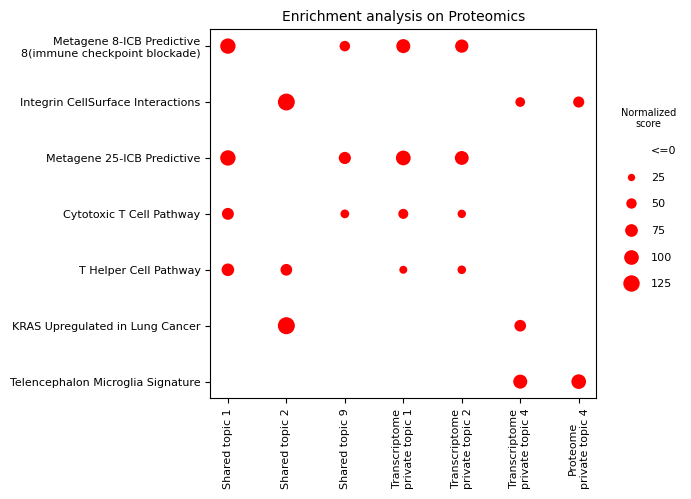

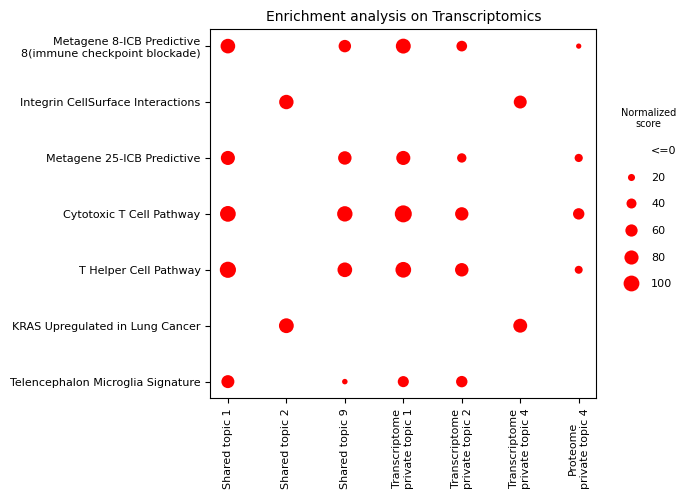

In [21]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_enrichment_dotplot(df, dot_color='steelblue', dot_scale=300, figsize=(8, 10), title=None, file_path=None):
    """
    Plot a dotplot from a (cluster × pathway) DataFrame.
    Size of dots reflects the value. Color is fixed.

    Parameters:
    - df: pandas DataFrame, rows = clusters, columns = pathways
    - dot_color: color of all dots
    - dot_scale: multiplier for dot size
    - figsize: figure size
    """
    # Melt the dataframe to long format
    data = df.reset_index().melt(id_vars='index', var_name='Pathway', value_name='GSVA enrichment score')
    data.rename(columns={'index': 'Cluster'}, inplace=True)

    # Apply square root scaling to scores (for better dot size contrast)
    data['GSVA enrichment score'] = np.sqrt(np.clip(data['GSVA enrichment score'], a_min=0, a_max=None)) * dot_scale

    # Create the dotplot
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(
        data=data,
        x='Pathway',
        y='Cluster',
        size='GSVA enrichment score',
        sizes=(0, dot_scale),  # Not used directly since we pass Size manually
        color=dot_color,
        legend='auto'
    )
    # Get handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Find the index where the size legend starts (usually after the color legend, if any)
    # In your case, since only size is used, it's likely at the start
    # But to be robust, let's find the "Normalized\nscore" title
    if 'Normalized\nscore' in labels:
        size_legend_start = labels.index('Normalized\nscore') + 1
    else:
        size_legend_start = 0

    # Change the first size label to '<=0'
    if size_legend_start < len(labels):
        labels[size_legend_start] = '<=0'

    # Recreate the legend with modified labels
    legend = ax.legend(
        handles=handles,
        labels=labels,
        title='Normalized\nscore',
        bbox_to_anchor=(1.05, .8),
        loc='upper left',
        borderaxespad=0,
        frameon=False,
        labelspacing=1.5,
        fontsize=8
    )
    legend.get_title().set_ha('center')
    
    plt.xlabel('', fontsize=8)
    plt.ylabel('', fontsize=8)
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=10)
    plt.tight_layout()
    if file_path is not None:
        plt.savefig(file_path)
    plt.show()



pathway_pro = pd.read_csv('../Results/Mouse_Thymus/protein/m2/log2fc_results.csv', index_col=0)
pathway_rna = pd.read_csv('../Results/Mouse_Thymus/rna/m2/log2fc_results.csv', index_col=0)

# new scale
pathway_pro = pathway_pro.loc[['ZENG_GU_ICB_CONTROL_METAGENE_8_PRECICTIVE_ICB_RESPONSE', 'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS',
                               'ZENG_GU_ICB_CONTROL_METAGENE_25_PRECICTIVE_ICB_RESPONSE', 'BIOCARTA_TCYTOTOXIC_PATHWAY',
                               'BIOCARTA_THELPER_PATHWAY', 'SWEET_LUNG_CANCER_KRAS_UP', 'HEVNER_TELENCEPHALON_MICROGLIA']]

pathway_pro = pathway_pro.rename(index={'ZENG_GU_ICB_CONTROL_METAGENE_8_PRECICTIVE_ICB_RESPONSE': 'Metagene 8-ICB Predictive\n8(immune checkpoint blockade)', 
                                        'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS': 'Integrin CellSurface Interactions', 
                                        'ZENG_GU_ICB_CONTROL_METAGENE_25_PRECICTIVE_ICB_RESPONSE': 'Metagene 25-ICB Predictive',
                                        'BIOCARTA_TCYTOTOXIC_PATHWAY': 'Cytotoxic T Cell Pathway',
                                        'BIOCARTA_THELPER_PATHWAY': 'T Helper Cell Pathway',
                                        'SWEET_LUNG_CANCER_KRAS_UP': 'KRAS Upregulated in Lung Cancer',
                                        'HEVNER_TELENCEPHALON_MICROGLIA': 'Telencephalon Microglia Signature'})
pathway_pro = pathway_pro.rename(columns={'Transcriptomics private topic 1': 'Transcriptome\nprivate topic 1', 'Transcriptomics private topic 2': 'Transcriptome\nprivate topic 2',
                                          'Transcriptomics private topic 4': 'Transcriptome\nprivate topic 4', 'Proteomics private topic 4': 'Proteome\nprivate topic 4'})

pathway_pro = pathway_pro[['Shared topic 1', 'Shared topic 2', 'Shared topic 9',
                           'Transcriptome\nprivate topic 1', 'Transcriptome\nprivate topic 2',
                           'Transcriptome\nprivate topic 4', 'Proteome\nprivate topic 4']]


pathway_rna = pathway_rna.loc[['ZENG_GU_ICB_CONTROL_METAGENE_8_PRECICTIVE_ICB_RESPONSE', 'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS',
                               'ZENG_GU_ICB_CONTROL_METAGENE_25_PRECICTIVE_ICB_RESPONSE', 'BIOCARTA_TCYTOTOXIC_PATHWAY',
                               'BIOCARTA_THELPER_PATHWAY', 'SWEET_LUNG_CANCER_KRAS_UP', 'HEVNER_TELENCEPHALON_MICROGLIA']]

pathway_rna = pathway_rna.rename(index={'ZENG_GU_ICB_CONTROL_METAGENE_8_PRECICTIVE_ICB_RESPONSE': 'Metagene 8-ICB Predictive\n8(immune checkpoint blockade)', 
                                        'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS': 'Integrin CellSurface Interactions', 
                                        'ZENG_GU_ICB_CONTROL_METAGENE_25_PRECICTIVE_ICB_RESPONSE': 'Metagene 25-ICB Predictive',
                                        'BIOCARTA_TCYTOTOXIC_PATHWAY': 'Cytotoxic T Cell Pathway',
                                        'BIOCARTA_THELPER_PATHWAY': 'T Helper Cell Pathway',
                                        'SWEET_LUNG_CANCER_KRAS_UP': 'KRAS Upregulated in Lung Cancer',
                                        'HEVNER_TELENCEPHALON_MICROGLIA': 'Telencephalon Microglia Signature'})
pathway_rna = pathway_rna.rename(columns={'Transcriptomics private topic 1': 'Transcriptome\nprivate topic 1', 'Transcriptomics private topic 2': 'Transcriptome\nprivate topic 2',
                                          'Transcriptomics private topic 4': 'Transcriptome\nprivate topic 4', 'Proteomics private topic 4': 'Proteome\nprivate topic 4'})

pathway_rna = pathway_rna[['Shared topic 1', 'Shared topic 2', 'Shared topic 9',
                           'Transcriptome\nprivate topic 1', 'Transcriptome\nprivate topic 2',
                           'Transcriptome\nprivate topic 4', 'Proteome\nprivate topic 4']]

pathway_pro_T = pathway_pro.T
pathway_rna_T = pathway_rna.T
plot_enrichment_dotplot(pathway_pro, title='Enrichment analysis on Proteomics', dot_color='red', dot_scale=150, figsize=(7, 5), file_path='../Figures/visualisation_6_enrichment_pro.pdf')
plot_enrichment_dotplot(pathway_rna, title='Enrichment analysis on Transcriptomics', dot_color='red', dot_scale=150, figsize=(7, 5), file_path='../Figures/visualisation_6_enrichment_rna.pdf')

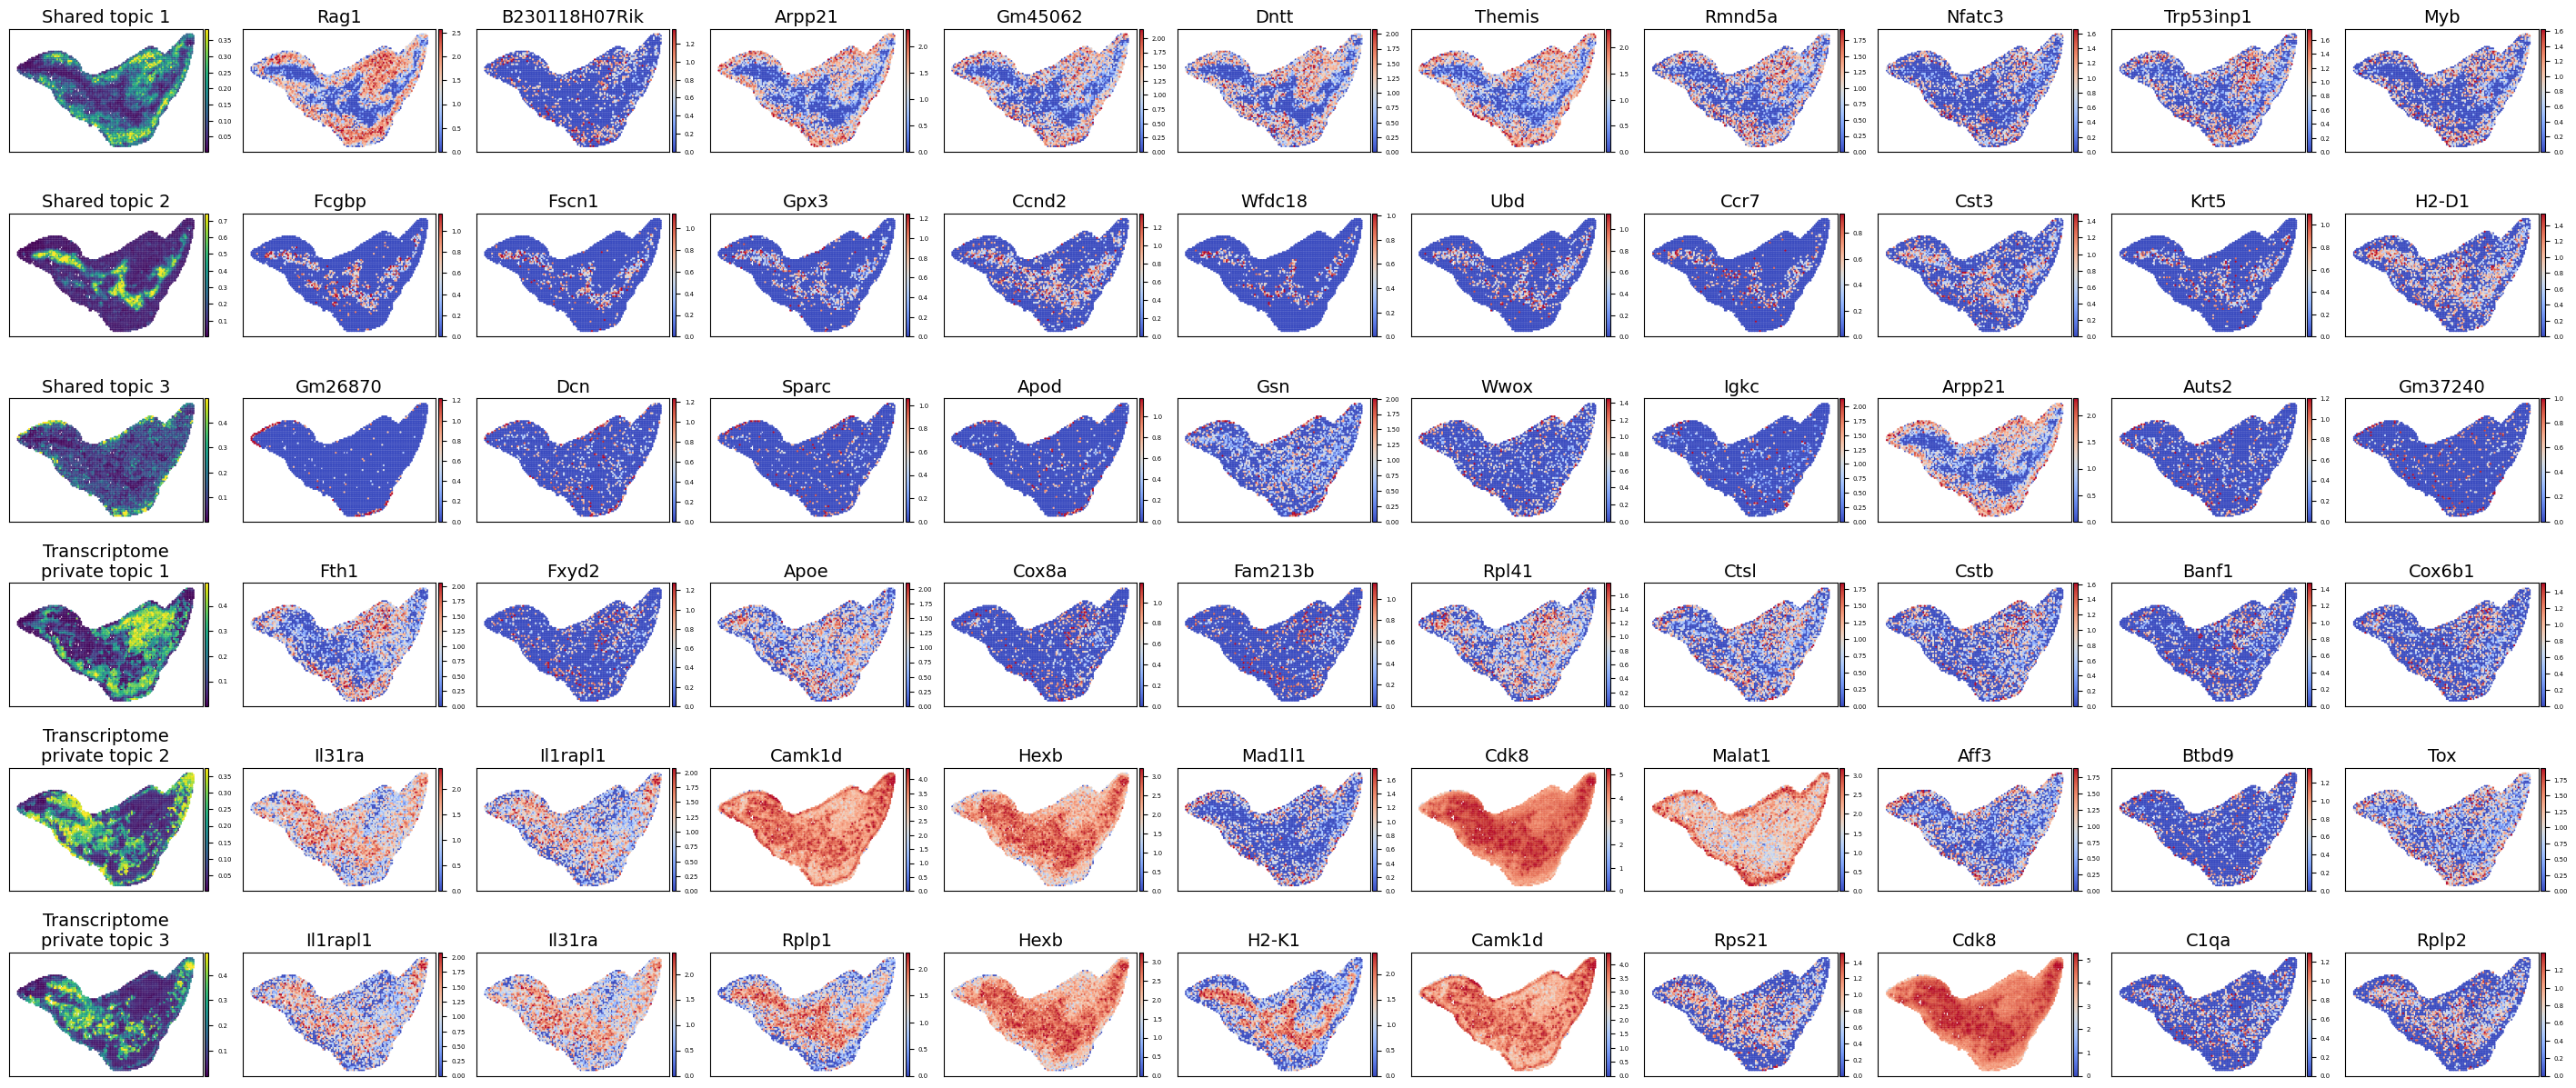

In [ ]:
import sys
import os
# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(os.path.dirname(current_dir)))
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
dataset = 'Mouse_Thymus'
plt.rcParams['font.size'] = 5
# sc.set_figure_params(scanpy=True, fontsize=5)
z = pd.read_csv('../Results/' + dataset + '/SpaMV_z.csv', index_col=0)
w = pd.read_csv('../Results/' + dataset + '/SpaMV_w_Transcriptomics.csv', index_col=0)
col_dict = {}
si = 1
oi = 1
ti = 1
for topic in z.columns:
    if 'Shared' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(si)
        si += 1
    elif 'Transcriptomics' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(oi)
        oi += 1
    else:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(ti)
        ti += 1
z = z.rename(columns=col_dict)
w = w.rename(columns=col_dict)
rows = w.shape[1]
columns = 11
d = sc.read_h5ad('../Results/' + dataset + '/adata_RNA_preprocessed.h5ad')
d = d[z.index]
d.obs[z.columns] = z.values
sf = 2
space = 0.2
fig = plt.figure(figsize=(columns * sf * 1.3, rows * sf))
spec_dr = GridSpec(rows, columns, hspace=space +.3, wspace=space-.1)
spec_dr.update(left=0, right=.98, top=.98, bottom=0.02)
f_dict = {}
i = 0
for i in range(rows):
    genes = w.nlargest(columns - 1, w.columns[i]).index
    for j in range(columns):
        f_dict[w.columns[i] + str(j)] = plt.subplot(spec_dr[i, j])
        if j == 0:
            sc.pl.embedding(d, color=w.columns[i], basis='spatial', size=10, ax=f_dict[w.columns[i] + str(j)], show=False, frameon=True, legend_loc='none', vmax='p99')
            label = w.columns[i].replace('Transcriptomics', 'Transcriptome')
            if 'Transcriptome' in label:
                label = label.split(maxsplit=1)[0] + '\n' + label.split(maxsplit=1)[1]
            f_dict[w.columns[i] + str(j)].set_title(label, fontsize=14, pad=5)
        else:
            sc.pl.embedding(d, color=genes[j - 1], basis='spatial', size=10, ax=f_dict[w.columns[i] + str(j)], show=False, frameon=True, legend_loc='none', vmax='p99', cmap='coolwarm')
            f_dict[w.columns[i] + str(j)].set_title(genes[j - 1], fontsize=14, pad=5)
        f_dict[w.columns[i] + str(j)].axes.get_xaxis().set_visible(False)
        f_dict[w.columns[i] + str(j)].axes.get_yaxis().set_visible(False)
        
plt.savefig('../Figures/visualisation_6_RNA.pdf')
plt.show()

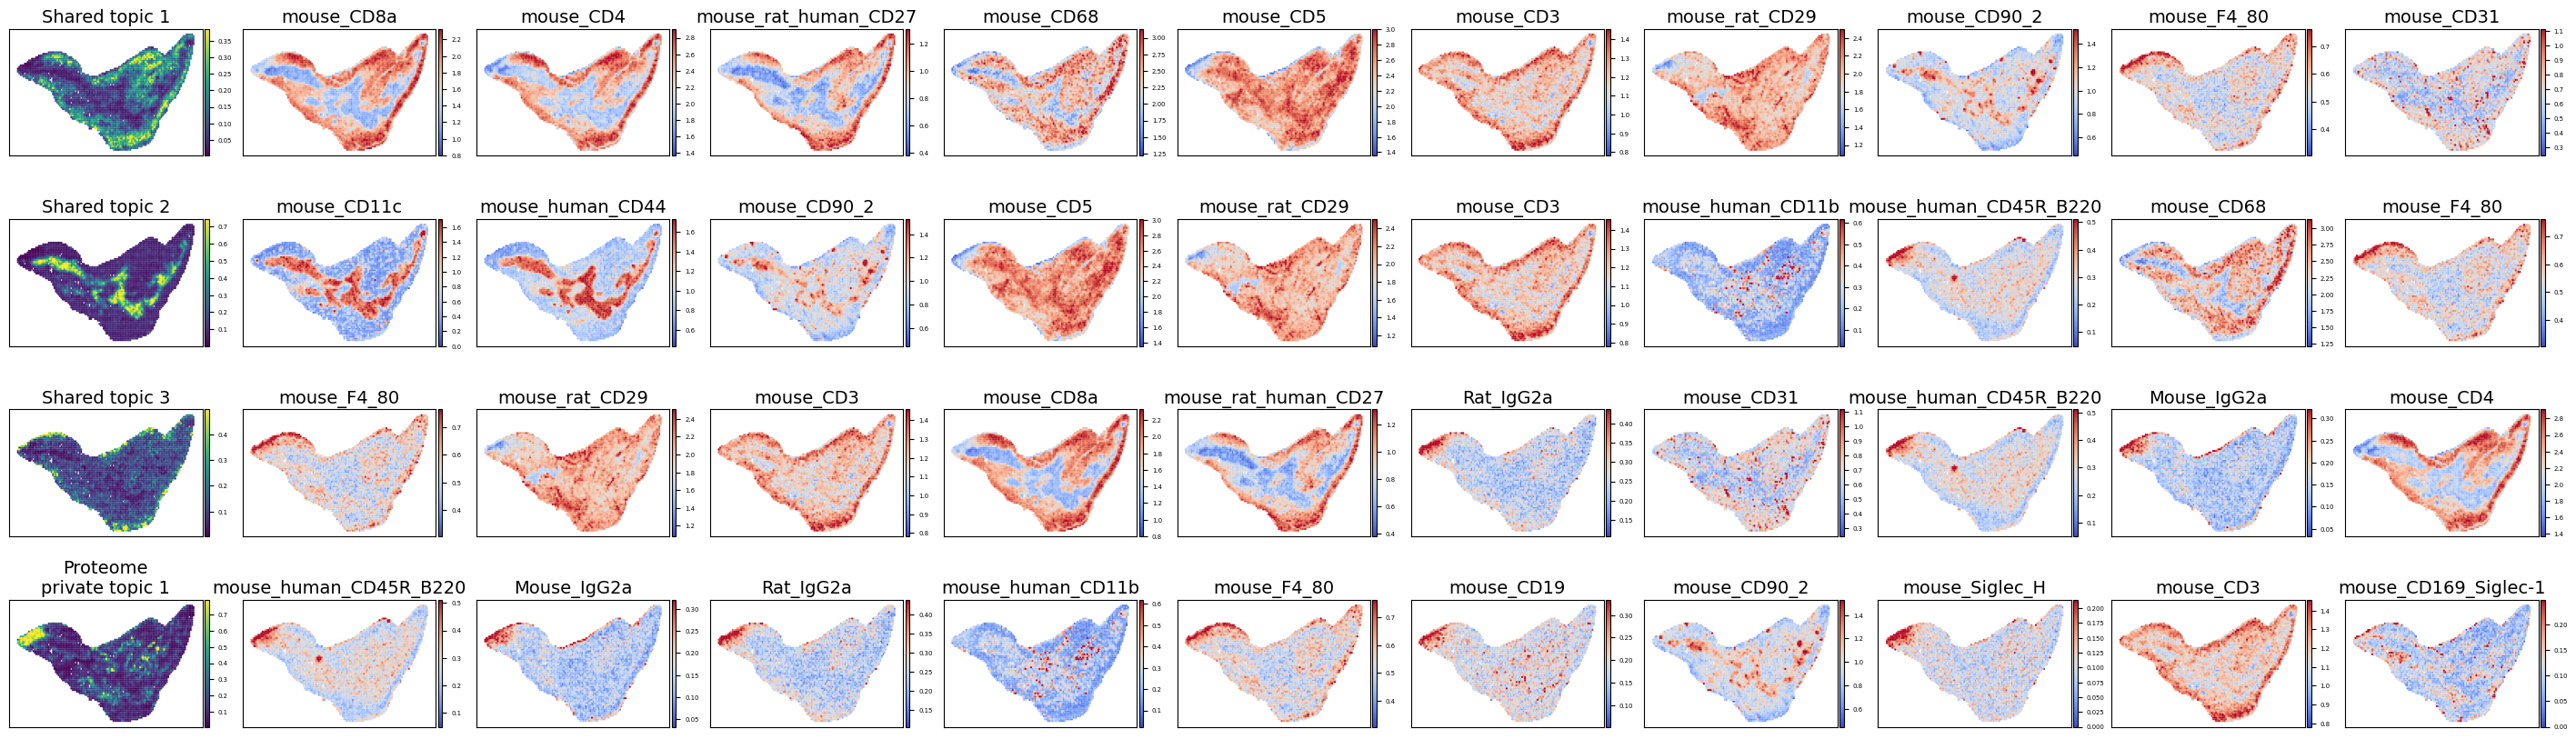

In [ ]:
import sys
import os
# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(os.path.dirname(current_dir)))
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
dataset = 'Mouse_Thymus'
plt.rcParams['font.size'] = 5
# sc.set_figure_params(scanpy=True, fontsize=5)
z = pd.read_csv('../Results/' + dataset + '/SpaMV_z.csv', index_col=0)
w = pd.read_csv('../Results/' + dataset + '/SpaMV_w_Proteomics.csv', index_col=0)
col_dict = {}
si = 1
oi = 1
ti = 1
for topic in z.columns:
    if 'Shared' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(si)
        si += 1
    elif 'Transcriptomics' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(oi)
        oi += 1
    else:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(ti)
        ti += 1
z = z.rename(columns=col_dict)
w = w.rename(columns=col_dict)
rows = w.shape[1]
columns = 11
d = sc.read_h5ad('../Results/' + dataset + '/adata_ADT_preprocessed.h5ad')
# d = sc.read_h5ad('../../Dataset/' + dataset + '/adata_H3K27ac_ATAC.h5ad')
d = d[z.index]
d.obs[z.columns] = z.values
sf = 2
space = 0.2
fig = plt.figure(figsize=(columns * sf * 1.3, rows * sf))
spec_dr = GridSpec(rows, columns, hspace=space+ .3, wspace=space-.1)
spec_dr.update(left=0, right=.98, top=.98, bottom=0.02)
f_dict = {}
i = 0
for i in range(rows):
    genes = w.nlargest(columns - 1, w.columns[i]).index
    for j in range(columns):
        f_dict[w.columns[i] + str(j)] = plt.subplot(spec_dr[i, j])
        if j == 0:
            sc.pl.embedding(d, color=w.columns[i], basis='spatial', size=10, ax=f_dict[w.columns[i] + str(j)], show=False, frameon=True, legend_loc='none', vmax='p99')
            label = w.columns[i].replace('Proteomics', 'Proteome')
            if 'Proteome' in label:
                label = label.split(maxsplit=1)[0] + '\n' + label.split(maxsplit=1)[1]
            f_dict[w.columns[i] + str(j)].set_title(label, fontsize=14, pad=5)
        else:
            sc.pl.embedding(d, color=genes[j - 1], basis='spatial', size=10, ax=f_dict[w.columns[i] + str(j)], show=False, frameon=True, legend_loc='none', vmax='p99', cmap='coolwarm')
            f_dict[w.columns[i] + str(j)].set_title(genes[j - 1], fontsize=14, pad=5)
        f_dict[w.columns[i] + str(j)].axes.get_xaxis().set_visible(False)
        f_dict[w.columns[i] + str(j)].axes.get_yaxis().set_visible(False)
        
plt.savefig('../Figures/visualisation_6_PRO.pdf')
plt.show()

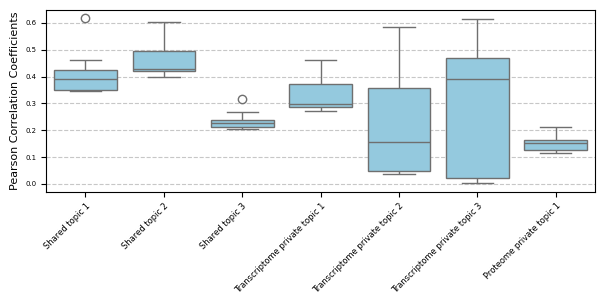

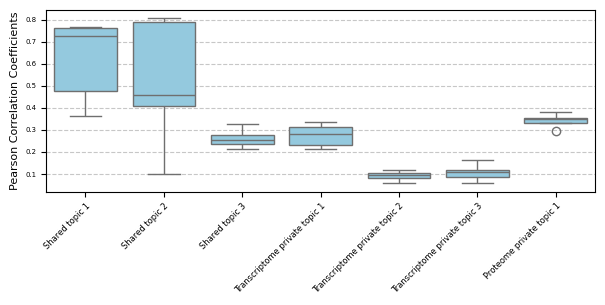

In [ ]:
import sys
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(os.path.dirname(current_dir)))
from Methods.SpaMV_copy.utils import plot_top_positive_correlations_boxplot

dataset = 'Mouse_Thymus'
z = pd.read_csv('../Results/' + dataset + '/SpaMV_z.csv', index_col=0)
col_dict = {}
si = 1
oi = 1
ti = 1
for topic in z.columns:
    if 'Shared' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(si)
        si += 1
    elif 'Transcriptomics' in topic:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(oi)
        oi += 1
    else:
        col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(ti)
        ti += 1
z = z.rename(columns=col_dict)
z.index = z.index.astype(str)

for topic in z.columns:
    z = z.rename(columns={topic: topic.replace('Transcriptomics', 'Transcriptome')})
    z = z.rename(columns={topic: topic.replace('Proteomics', 'Proteome')})
d = [sc.read_h5ad('../Results/' + dataset + '/adata_RNA_preprocessed.h5ad'), sc.read_h5ad('../Results/' + dataset + '/adata_ADT_preprocessed.h5ad')]
omics_names = ['Transcriptomics', 'Proteomics']
for i in range(len(d)):
    plot_top_positive_correlations_boxplot(d[i], z, omics_name=omics_names[i], figsize=(6, 3))
    plt.savefig('../Figures/visualisation_6_' + omics_names[i] + '_pcc.pdf')

In [ ]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
from Methods.SpaMV_copy.utils import pca, clr_normalize_each_cell, ST_preprocess, clustering, preprocess_dc

data = 'Mouse_Thymus'

n_clusters = 7
data2 = sc.read_h5ad('../Dataset/' + data + '/adata_ADT.h5ad')
omics_names = ['Transcriptomics', 'Proteomics']
data1 = sc.read_h5ad('../Dataset/' + data + '/adata_RNA.h5ad')

datas = preprocess_dc([data1, data2], omics_names)
datas[0] = datas[0][:, datas[0].var_names[datas[0].X.std(0) > 1e-10]]
datas[1] = datas[1][:, datas[1].var_names[datas[1].X.std(0) > 1e-10]]
clustering(datas[0], key='embedding', add_key=omics_names[0], n_clusters=n_clusters, method='mclust', use_pca=True)
clustering(datas[1], key='embedding', add_key=omics_names[1], n_clusters=n_clusters, method='mclust', use_pca=True)
spamv = sc.read_h5ad('../Results/' + dataset + '/SpaMV.h5ad')
spamv_plot = spamv.copy()
spamv_plot.obs['SpaMV'] = spamv.obs['SpaMV'].astype(int).map({1: '1-Medulla', 2: '2-Medulla', 3: '3-Cortex', 4: '4-Thymic corpuscle', 5: '5-Thymic corpuscle', 6: '6-Capsule', 7: '7-Cortex'}).astype('category')

adata_rna = sc.read_h5ad('../Dataset/'+ data + '/adata_RNA.h5ad')
adata_adt = sc.read_h5ad('../Dataset/'+ data + '/adata_ADT.h5ad')
adata_adt.var_names = adata_adt.var_names.map(
    lambda x: 'CD45R_B220' if x == 'mouse_human_CD45R_B220' else x
)
adata_adt.var_names = adata_adt.var_names.map(
    lambda x: 'CD27' if x == 'mouse_rat_human_CD27' else x
)
adata_adt.var_names = adata_adt.var_names.map(
    lambda x: 'CD11b' if x == 'mouse_human_CD11b' else x
)
adata_adt.var_names = adata_adt.var_names.map(
    lambda x: 'CD44' if x == 'mouse_human_CD44' else x
)
adata_adt.var_names = adata_adt.var_names.map(
    lambda x: 'CD169' if x == 'mouse_CD169_Siglec-1' else x
)
adata_adt.var_names = adata_adt.var_names.map(
    lambda x: 'Siglec_H' if x == 'mouse_Siglec_H' else x
)
adata_rna = adata_rna[spamv.obs_names, :]
adata_rna.obs['SpaMV'] = spamv.obs['SpaMV']
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.tl.rank_genes_groups(adata_rna, 'SpaMV', method='wilcoxon', key_added = "wilcoxon")

adata_adt = adata_adt[spamv.obs_names, :]
adata_adt.obs['SpaMV'] = spamv.obs['SpaMV']
adata_adt = clr_normalize_each_cell(adata_adt)
sc.tl.rank_genes_groups(adata_adt, 'SpaMV', method='wilcoxon', key_added = "wilcoxon")

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


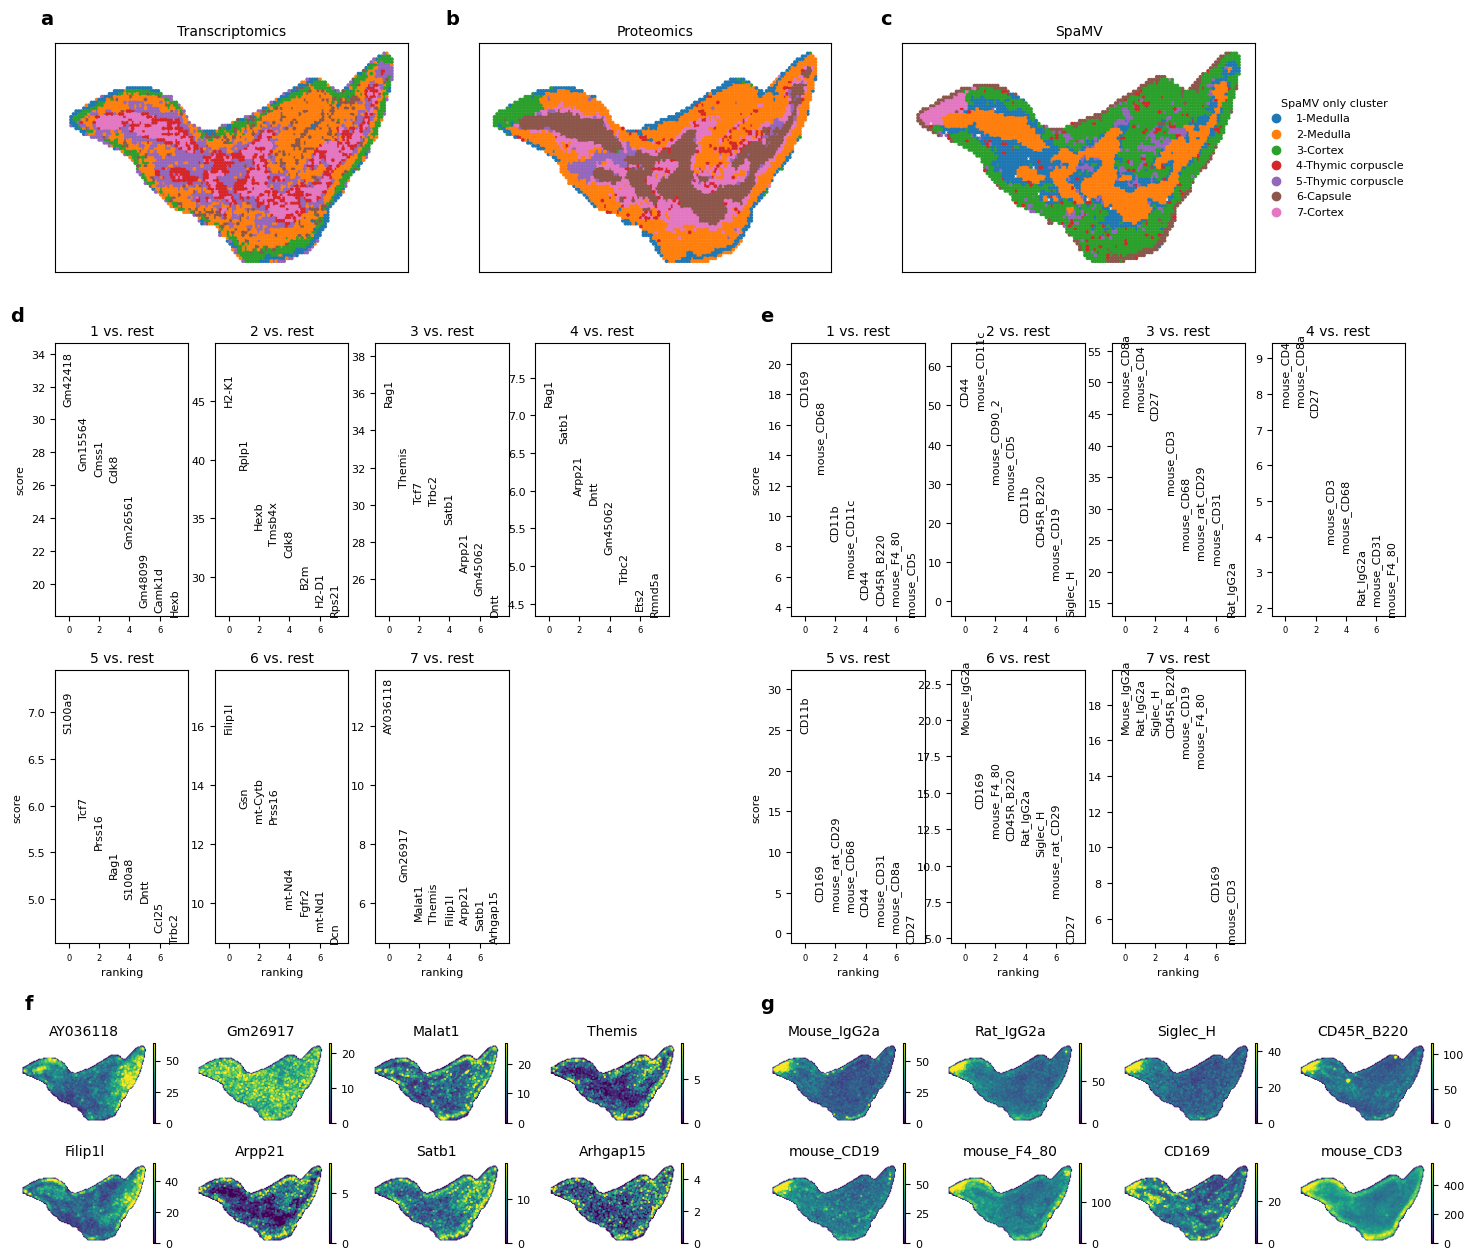

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
plt.rc('font', size=8)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=6)

data = 'Mouse_Thymus'
width = 15
height = 13.5
width_ratio=.8
clustering_scale = {'top':1 - 1/height, 'bottom':1 - (1 + width_ratio * width / 1.75 / 3)/height, 'left': .05, 'right': width_ratio + .05}
def_scale = {'top':1 - 4/height, 'bottom':1 - 10/height, 'left': .05, 'right': .95}

rna_scale = {'top': 1 - 11/height, 'bottom': 1 - 13/height, 'left':.025, 'right': .475}
adt_scale = {'top': 1 - 11/height, 'bottom': 1 - 13/height, 'left':.525, 'right': .975}
fig = plt.figure(figsize=(width, height))
ari = {}

spec_clustering = GridSpec(1, 3)
spec_clustering.update(**clustering_scale)
f_dict['RNA'] = plt.subplot(spec_clustering[0, 0])
sc.pl.embedding(datas[0], basis='spatial', color=omics_names[0], size=30, show=False, title='Transcriptomics', ax=f_dict['RNA'], legend_loc=None)
f_dict['ADT'] = plt.subplot(spec_clustering[0, 1])
sc.pl.embedding(datas[1], basis='spatial', color=omics_names[1], size=30, show=False, title='Proteomics', ax=f_dict['ADT'], legend_loc=None)

f_dict['SpaMV'] = plt.subplot(spec_clustering[0, 2])
sc.pl.embedding(spamv_plot, color='SpaMV', basis='spatial', size=30, show=False, ax=f_dict['SpaMV'])
f_dict['SpaMV'].get_legend().set_title(title='SpaMV only cluster')
for f in f_dict.values():
    # f.get_legend().remove()
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

spec_def = GridSpec(1, 2)
spec_def.update(**def_scale)
f_dict['deg'] = plt.subplot(spec_def[0, 0])
f_dict['dep'] = plt.subplot(spec_def[0, 1])
sc.pl.rank_genes_groups(adata_rna, n_genes=8, sharey=False, key="wilcoxon", show=False, ax=f_dict['deg'])
f_dict['deg'].spines['top'].set_visible(False)
f_dict['deg'].spines['right'].set_visible(False)
f_dict['deg'].spines['bottom'].set_visible(False)
f_dict['deg'].spines['left'].set_visible(False)
f_dict['deg'].get_xaxis().set_ticks([])
f_dict['deg'].get_yaxis().set_ticks([])
sc.pl.rank_genes_groups(adata_adt, n_genes=8, sharey=False, key="wilcoxon", show=False, ax=f_dict['dep'])
f_dict['dep'].spines['top'].set_visible(False)
f_dict['dep'].spines['right'].set_visible(False)
f_dict['dep'].spines['bottom'].set_visible(False)
f_dict['dep'].spines['left'].set_visible(False)
f_dict['dep'].get_xaxis().set_ticks([])
f_dict['dep'].get_yaxis().set_ticks([])

adata_rna_raw = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')
adata_adt_raw = sc.read_h5ad('../Dataset/' + dataset + '/adata_ADT.h5ad')
adata_adt_raw.var_names = adata_adt_raw.var_names.map(lambda x: 'CD45R_B220' if x == 'mouse_human_CD45R_B220' else x)
adata_adt_raw.var_names = adata_adt_raw.var_names.map(lambda x: 'CD27' if x == 'mouse_rat_human_CD27' else x)
adata_adt_raw.var_names = adata_adt_raw.var_names.map(lambda x: 'CD11b' if x == 'mouse_human_CD11b' else x)
adata_adt_raw.var_names = adata_adt_raw.var_names.map(lambda x: 'CD44' if x == 'mouse_human_CD44' else x)
adata_adt_raw.var_names = adata_adt_raw.var_names.map(lambda x: 'CD169' if x == 'mouse_CD169_Siglec-1' else x)
adata_adt_raw.var_names = adata_adt_raw.var_names.map(lambda x: 'Siglec_H' if x == 'mouse_Siglec_H' else x)

spec_rna = GridSpec(2, 4, hspace=.5)
spec_rna.update(**rna_scale)
i = 0
j = 0
for g in sc.get.rank_genes_groups_df(adata_rna, group='7', key='wilcoxon')['names'][:8]:
    f_dict[g] = plt.subplot(spec_rna[i, j])
    sc.pl.embedding(adata_rna_raw, color=g, basis='spatial', vmax='p99', size=10, show=False, ax=f_dict[g], frameon=False)
    j += 1
    if j == 4:
        i += 1
        j = 0
spec_adt = GridSpec(2, 4, hspace=.5)
spec_adt.update(**adt_scale)
i = 0
j = 0
for g in sc.get.rank_genes_groups_df(adata_adt, group='7', key='wilcoxon')['names'][:8]:
    f_dict[g] = plt.subplot(spec_adt[i, j])
    sc.pl.embedding(adata_adt_raw, color=g, basis='spatial', vmax='p99', size=10, show=False, ax=f_dict[g], frameon=False)
    j += 1
    if j == 4:
        i += 1
        j = 0
# for f in f_dict.values():
#     f.spines['top'].set_visible(False)
#     f.spines['right'].set_visible(False)
#     f.spines['bottom'].set_visible(False)
#     f.spines['left'].set_visible(False)
#     f.get_xaxis().set_ticks([])
#     f.get_yaxis().set_ticks([])
plt.tight_layout()
fs = 14
fig.text(.04, .94, 'a', fontsize=fs, fontweight='bold')
fig.text(.31, .94, 'b', fontsize=fs, fontweight='bold')
fig.text(.6, .94, 'c', fontsize=fs, fontweight='bold')
fig.text(.02, .72, 'd', fontsize=fs, fontweight='bold')
fig.text(.52, .72, 'e', fontsize=fs, fontweight='bold')
fig.text(.03, .21, 'f', fontsize=fs, fontweight='bold')
fig.text(.52, .21, 'g', fontsize=fs, fontweight='bold')
plt.savefig('../Figures/visualisation_6_pca.pdf', transparent=True)
plt.show()